In [1]:
import scipy.io
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
from numpy import genfromtxt
from aux_functions2 import xavier_init
from aux_functions2 import plot #MINE

import csv
import sys

In [2]:
steps = 20000 # int(sys.argv[1])  # number of training steps
iteration = 10 # int(sys.argv[2])  # number of iterations (iid runs)
d = 50 # int(sys.argv[3])  # dimension of the distributions
mb_size = 40000 # int(sys.argv[4])  # batch size
N = 300000
rho_range = [0.1, 0.3, 0.5, 0.7, 0.9]
print(steps)
print(iteration)
print(d)
print(mb_size)
print(N)


20000
10
50
40000
300000


In [3]:
# hyperparameters
if d==4:
    layers = [d, 8, 8, 4, 1]
elif d==20:
    layers = [d, 32, 32, 16, 1]
elif d==50:
    layers = [d, 32, 32, 16, 1] # [d, 64, 64, 32, 1]
else:                      
    print('check dimension!')

lam = 1.0 # lambda=beta+gamma

# initialize
X = tf.placeholder(tf.float32, shape=[None, d])
Y = tf.placeholder(tf.float32, shape=[None, d])

def initialize_NN(layers):
    NN_W = []
    NN_b = []
    num_layers = len(layers)
    for l in range(0,num_layers-1):
        W = tf.Variable(xavier_init(size=[layers[l], layers[l+1]]), name="W")
        b = tf.Variable(tf.zeros([1,layers[l+1]], dtype=tf.float32), dtype=tf.float32)
        NN_W.append(W)
        NN_b.append(b)
    return NN_W, NN_b

D_W, D_b = initialize_NN(layers)

theta_D = [D_W, D_b] 


In [4]:
def discriminator(x):
    num_layers = len(D_W) + 1
    
    h = x  
    for l in range(0,num_layers-2):
        W = D_W[l]
        b = D_b[l]
        h = tf.tanh(tf.add(tf.matmul(h, W), b))
    
    W = D_W[-1]
    b = D_b[-1]
    out = 50.0 * tf.nn.tanh(tf.add(tf.matmul(h, W), b) / 50.0) # bound M=50
    #out = 20.0 * tf.nn.tanh(tf.add(tf.matmul(h, W), b) / 20.0)

    return out

D_real = discriminator(X)
D_fake = discriminator(Y)


In [5]:
config = tf.ConfigProto(device_count={'GPU': 0})
sess = tf.Session(config=config)
sess.run(tf.global_variables_initializer())

SF = 1000
D_loss_vals =  np.zeros(shape=(len(rho_range), iteration)) 
RD_exact_rho =  np.zeros(shape= len(rho_range))


In [6]:

# estimate Renyi divergence

# Loop over #samples, then over iid iterations and then over training steps
for j, rho in enumerate(rho_range): 
    
    print('j=', j)
    print('rho=', rho)
    
    # load data
    fname = 'data/varying_rho_Sigma1_eye_2/d_' + str(d) + '/input_N' + str(N) + '_dim' + str(d) + '/gaussian_d_' + str(d) + '_'
    data = scipy.io.loadmat(fname + 'data_'+str(rho)+'.mat')
    x_ = np.array(data['x'])
    y_ = np.array(data['y'])

    params = scipy.io.loadmat(fname + 'params_'+str(rho)+'.mat')
    alpha = np.array(params['alpha'])
    No_alpha = alpha.shape[0]

    RD_exact = np.array(params['RD_exact']) # contains exact for all alphas. In current datafiles, only one

    
    beta = lam*(1-alpha[0])  #   <----------- choose the first alpha value
    gamma = lam*alpha[0]  #  <---------- choose the first alpha value
    
    #exact value for Renyi (estimated by integral computation)
    RD_exact_rho[j] = RD_exact[0];
    
    # variational representation:
    if beta == 0:
        D_loss_real = -tf.reduce_mean(D_real)
    else:
        max_val = tf.reduce_max((-beta) * D_real)
        D_loss_real = (1.0 / beta) * (tf.log(tf.reduce_mean(tf.exp((-beta) * D_real - max_val))) + max_val)

    if gamma == 0:
        D_loss_fake = tf.reduce_mean(D_fake)

    else:
        max_val = tf.reduce_max((gamma) * D_fake)
        D_loss_fake = (1.0 / gamma) * (tf.log(tf.reduce_mean(tf.exp(gamma * D_fake - max_val))) + max_val)

    D_loss = D_loss_real + D_loss_fake
    total_loss = D_loss

    #D_solver = tf.train.AdamOptimizer().minimize(total_loss, var_list=theta_D)
    D_solver = tf.train.AdamOptimizer(learning_rate=0.0005).minimize(total_loss, var_list=theta_D)

    for iter in range(iteration):
        print('Iteration: {}'.format(iter))
        sess.run(tf.global_variables_initializer())

        x = x_[np.random.randint(x_.shape[0], size=int(0.8*x_.shape[0])), :]
        y = y_[np.random.randint(y_.shape[0], size=int(0.8*x_.shape[0])), :]

        # initialize for plotting
        i = 0
        Pl_freq = 10
        D_loss_plot = np.zeros(shape=((np.rint(steps / Pl_freq)).astype(int), 1))  # because we writeout every Pl_freq

        for it in range(steps):
            X_mb = x[np.random.randint(x.shape[0], size=mb_size), :]
            Y_mb = y[np.random.randint(y.shape[0], size=mb_size), :]

            _, D_loss_curr, D_tot_loss = sess.run([D_solver, D_loss, total_loss], feed_dict={X: X_mb, Y: Y_mb})

            if it % Pl_freq == 0:
                D_loss_plot[i] = D_loss_curr
                i += 1

            if it % SF == 0:
                print('Iter: {}'.format(it))
                print('Renyi divergence: {}'.format(-lam*D_loss_curr))
                print()


        D_loss_curr = sess.run(D_loss, feed_dict={X: x, Y: y})
        D_loss_vals[j,iter] = -lam * D_loss_curr

 
    # -----------------------------------------------------------------------------
    # Plotting
    # -----------------------------------------------------------------------------
    if not os.path.exists('data/out_gaussian_BS_plots/'):
        os.makedirs('data/out_gaussian_BS_plots/')

    fig = plt.figure()
    #plt.plot(D_loss_plot)
    x_idx = np.linspace(0, steps, num=(np.rint(steps / Pl_freq)).astype(int))
    plt.plot(x_idx, D_loss_plot)
    plt.xlabel('steps')
    plt.ylabel('D loss')
    plt.savefig('data/out_gaussian_BS_plots/cgan_Dloss' + str(j) + 'rho_' + str(rho) +'.png', bbox_inches='tight')
    plt.close(fig)
   


j= 0
rho= 0.1
Iteration: 0
Iter: 0
Renyi divergence: [-3.1557865e-06]

Iter: 1000
Renyi divergence: [0.08628869]

Iter: 2000
Renyi divergence: [0.10442555]

Iter: 3000
Renyi divergence: [0.1043824]

Iter: 4000
Renyi divergence: [0.09768212]

Iter: 5000
Renyi divergence: [0.10531366]

Iter: 6000
Renyi divergence: [0.10777807]

Iter: 7000
Renyi divergence: [0.11004877]

Iter: 8000
Renyi divergence: [0.10306847]

Iter: 9000
Renyi divergence: [0.10727298]

Iter: 10000
Renyi divergence: [0.10909104]

Iter: 11000
Renyi divergence: [0.11655986]

Iter: 12000
Renyi divergence: [0.11283827]

Iter: 13000
Renyi divergence: [0.12104368]

Iter: 14000
Renyi divergence: [0.11543107]

Iter: 15000
Renyi divergence: [0.10988212]

Iter: 16000
Renyi divergence: [0.11829495]

Iter: 17000
Renyi divergence: [0.1147548]

Iter: 18000
Renyi divergence: [0.11995649]

Iter: 19000
Renyi divergence: [0.10984349]

Iteration: 1
Iter: 0
Renyi divergence: [-5.1568495e-06]

Iter: 1000
Renyi divergence: [0.08761954]

Iter

Iter: 6000
Renyi divergence: [0.11011183]

Iter: 7000
Renyi divergence: [0.10734868]

Iter: 8000
Renyi divergence: [0.11209047]

Iter: 9000
Renyi divergence: [0.11056256]

Iter: 10000
Renyi divergence: [0.1059047]

Iter: 11000
Renyi divergence: [0.11648977]

Iter: 12000
Renyi divergence: [0.11332226]

Iter: 13000
Renyi divergence: [0.10950851]

Iter: 14000
Renyi divergence: [0.11635756]

Iter: 15000
Renyi divergence: [0.10907626]

Iter: 16000
Renyi divergence: [0.11981058]

Iter: 17000
Renyi divergence: [0.11487603]

Iter: 18000
Renyi divergence: [0.1188612]

Iter: 19000
Renyi divergence: [0.11189127]

j= 1
rho= 0.3
Iteration: 0
Iter: 0
Renyi divergence: [-2.3406465e-06]

Iter: 1000
Renyi divergence: [0.7761049]

Iter: 2000
Renyi divergence: [0.82838583]

Iter: 3000
Renyi divergence: [0.81709194]

Iter: 4000
Renyi divergence: [0.82978725]

Iter: 5000
Renyi divergence: [0.84543395]

Iter: 6000
Renyi divergence: [0.8598733]

Iter: 7000
Renyi divergence: [0.86217904]

Iter: 8000
Renyi div

Iter: 14000
Renyi divergence: [0.86098766]

Iter: 15000
Renyi divergence: [0.8534577]

Iter: 16000
Renyi divergence: [0.87337065]

Iter: 17000
Renyi divergence: [0.86039686]

Iter: 18000
Renyi divergence: [0.8561845]

Iter: 19000
Renyi divergence: [0.84310246]

Iteration: 9
Iter: 0
Renyi divergence: [1.2052478e-06]

Iter: 1000
Renyi divergence: [0.7412684]

Iter: 2000
Renyi divergence: [0.77173376]

Iter: 3000
Renyi divergence: [0.80750155]

Iter: 4000
Renyi divergence: [0.7789216]

Iter: 5000
Renyi divergence: [0.7985444]

Iter: 6000
Renyi divergence: [0.7983794]

Iter: 7000
Renyi divergence: [0.8020842]

Iter: 8000
Renyi divergence: [0.80996776]

Iter: 9000
Renyi divergence: [0.8227005]

Iter: 10000
Renyi divergence: [0.8121023]

Iter: 11000
Renyi divergence: [0.82917356]

Iter: 12000
Renyi divergence: [0.816092]

Iter: 13000
Renyi divergence: [0.81605005]

Iter: 14000
Renyi divergence: [0.81702805]

Iter: 15000
Renyi divergence: [0.82998466]

Iter: 16000
Renyi divergence: [0.8214903

Iter: 4000
Renyi divergence: [2.349722]

Iter: 5000
Renyi divergence: [2.3724885]

Iter: 6000
Renyi divergence: [2.4004688]

Iter: 7000
Renyi divergence: [2.4380965]

Iter: 8000
Renyi divergence: [2.408409]

Iter: 9000
Renyi divergence: [2.4111185]

Iter: 10000
Renyi divergence: [2.409738]

Iter: 11000
Renyi divergence: [2.4263425]

Iter: 12000
Renyi divergence: [2.4094057]

Iter: 13000
Renyi divergence: [2.3916898]

Iter: 14000
Renyi divergence: [2.4775484]

Iter: 15000
Renyi divergence: [2.4095337]

Iter: 16000
Renyi divergence: [2.444801]

Iter: 17000
Renyi divergence: [2.4441485]

Iter: 18000
Renyi divergence: [2.4466507]

Iter: 19000
Renyi divergence: [2.4527369]

Iteration: 9
Iter: 0
Renyi divergence: [-3.4298282e-06]

Iter: 1000
Renyi divergence: [2.05165]

Iter: 2000
Renyi divergence: [2.1988983]

Iter: 3000
Renyi divergence: [2.3472528]

Iter: 4000
Renyi divergence: [2.3831644]

Iter: 5000
Renyi divergence: [2.3711238]

Iter: 6000
Renyi divergence: [2.3815956]

Iter: 7000
Reny

Iter: 16000
Renyi divergence: [6.7365065]

Iter: 17000
Renyi divergence: [6.6914196]

Iter: 18000
Renyi divergence: [6.624137]

Iter: 19000
Renyi divergence: [6.7203016]

Iteration: 8
Iter: 0
Renyi divergence: [-8.037314e-07]

Iter: 1000
Renyi divergence: [5.594423]

Iter: 2000
Renyi divergence: [5.929135]

Iter: 3000
Renyi divergence: [6.1166596]

Iter: 4000
Renyi divergence: [6.524042]

Iter: 5000
Renyi divergence: [6.622336]

Iter: 6000
Renyi divergence: [6.614105]

Iter: 7000
Renyi divergence: [6.6642656]

Iter: 8000
Renyi divergence: [6.711505]

Iter: 9000
Renyi divergence: [6.5971212]

Iter: 10000
Renyi divergence: [6.7700806]

Iter: 11000
Renyi divergence: [6.6983576]

Iter: 12000
Renyi divergence: [6.824103]

Iter: 13000
Renyi divergence: [6.6764975]

Iter: 14000
Renyi divergence: [6.7781334]

Iter: 15000
Renyi divergence: [6.731308]

Iter: 16000
Renyi divergence: [6.7128315]

Iter: 17000
Renyi divergence: [6.7492514]

Iter: 18000
Renyi divergence: [6.80766]

Iter: 19000
Renyi 

Iter: 7000
Renyi divergence: [31.143518]

Iter: 8000
Renyi divergence: [34.766068]

Iter: 9000
Renyi divergence: [29.023207]

Iter: 10000
Renyi divergence: [31.890142]

Iter: 11000
Renyi divergence: [31.95504]

Iter: 12000
Renyi divergence: [34.159065]

Iter: 13000
Renyi divergence: [29.549845]

Iter: 14000
Renyi divergence: [36.921402]

Iter: 15000
Renyi divergence: [21.641283]

Iter: 16000
Renyi divergence: [33.9386]

Iter: 17000
Renyi divergence: [32.287918]

Iter: 18000
Renyi divergence: [38.13536]

Iter: 19000
Renyi divergence: [23.290749]

Iteration: 8
Iter: 0
Renyi divergence: [4.013651e-06]

Iter: 1000
Renyi divergence: [18.071783]

Iter: 2000
Renyi divergence: [25.399456]

Iter: 3000
Renyi divergence: [31.673721]

Iter: 4000
Renyi divergence: [34.063087]

Iter: 5000
Renyi divergence: [29.790606]

Iter: 6000
Renyi divergence: [26.807806]

Iter: 7000
Renyi divergence: [33.71923]

Iter: 8000
Renyi divergence: [13.979732]

Iter: 9000
Renyi divergence: [22.217348]

Iter: 10000
Reny

In [7]:
print(D_loss_vals)

[[ 0.11796689  0.1172955   0.11774397  0.12009835  0.11919534  0.11725044
   0.11638451  0.11920047  0.11635923  0.11734915]
 [ 0.8836689   0.87010193  0.86016893  0.85373878  0.89626694  0.85563421
   0.84693813  0.8665235   0.85416985  0.82801867]
 [ 2.56755972  2.61982536  2.70836496  2.68785715  2.63975763  2.43117952
   2.61115694  2.43824291  2.45683098  2.41391134]
 [ 6.48871613  6.51171684  5.13031292  8.0411396   8.00527477  7.84890366
   7.61918926  6.73315144  6.8327198   7.56894064]
 [31.91955566 16.24729156 26.17268753 20.40575409 15.94012833 26.37024879
  37.9203949  37.37397003 30.67827225 29.59738541]]


In [8]:
   

with open('data/out_gaussian_BS_plots/'+'lambda_'+str(lam)+'_bs_'+str(mb_size)+'_nerd_'+str(rho)+'.csv', "w") as output:
    writer = csv.writer(output, lineterminator='\n')
    for val in D_loss_vals:
        writer.writerow(val)


Text(0, 0.5, 'divergence')

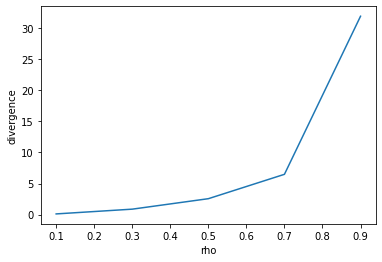

In [9]:
# Plot RD vs rho
#======================
fig = plt.figure()
plt.plot(rho_range, D_loss_vals[:,0])
plt.xlabel('rho')
plt.ylabel('divergence')

(0.0, 40.0)

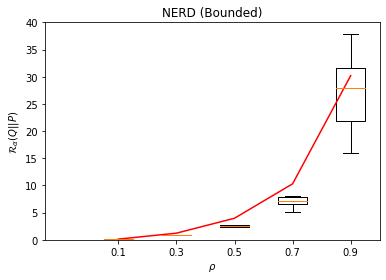

In [10]:


fig1, ax1 = plt.subplots()
ax1.set_title('NERD (Bounded)')
ax1.boxplot(np.transpose(D_loss_vals[:,:]) , labels=[0.1, 0.3, 0.5, 0.7, 0.9], whis=2)
ax1.plot(np.arange(1,len(rho_range)+1), RD_exact_rho[:],'r', 'LineWidth', 2 );
plt.xlabel(r'$\rho$')
plt.ylabel(r'$\mathcal{R}_{\alpha}(Q||P)$')
plt.ylim(0.0, 40.0)




In [11]:
print('program terminated succesfully')

program terminated succesfully
